# **Addestramento di una rete neurale Faster R-CNN per la detection di luoghi ad alto valore culturale**

Pezzo da aggiungere a /usr/local/lib/python3.6/dist-packages/albumentations/augmentations/bbox_utils.py

```
    bbox=list(bbox)

    for i in range(4):
      if (bbox[i]<0) :
        bbox[i]=0
      elif (bbox[i]>1) :
        bbox[i]=1

    bbox=tuple(bbox)
```



## Librerie


Clonazione del repository *vision* di *pytorch* per utilizzare alcune funzioni di utilità per l'addestramento e valutazione del modello.

In [25]:
%%shell

git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0       # Check current version

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../
cp references/detection/coco_eval.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at be376084 version check against PyTorch's CUDA version


Installazione della libreria albumentations con specifica versione 0.4.6.


Questa libreria verrà utilizzata per eseguire operazioni di trasformazione di *data augmentation* sui dati. 

In [26]:
! pip install albumentations==0.4.6

Librerie da importare:

In [27]:
# Core libraries
import os
import re
import glob
import numpy as np
import random
import time
import datetime
import xml.etree.ElementTree as ET

# PyTorch
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset
import transforms as T                          # Module transform  (helper functions)
import utils                                    # Module utils      (helper functions)
from engine import train_one_epoch, evaluate    # Module engine     (helper functions)

# Data Augmentation
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# Opencv
import cv2 as cv
from google.colab.patches import cv2_imshow

## Dataset

Sono stati individuati **24 punti di interesse** suddivisi in altrettante directories. 



Ogni punto di interesse contiene, a sua volta, altre tre directory:
- *imgs*: contiene le immagini di dimensione 900 x 1300;
- *annotations*: contiene le annotazioni (coordinate delle bounding box) di ogni immagine catturata;
- *bounding_box*: contiene le immagini con le bouding box individuate.


Il dataset è consultabile al seguente [link](https://drive.google.com/drive/folders/1MenVMP6C9Vuo7JJ-iesAd1KfsemAvSLy?usp=sharing)

### Connessione a Google Drive

Connessione a google drive per scaricare il dataset.

In [28]:
from google.colab import drive
drive.mount('/content/gdrive/')

path = "gdrive/MyDrive/DataSet/DatasetMonuments/"   # Replace with your path

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


### Caricamento del dataset

La funzione *get_bounding_boxes* permette di ottenere le coordinate di tutte le bouding boxes di uno specifico file .xml dato in input.

La funzione *format_labels* permette semplicemente di far 'matchare' le labels ottenute dal nome delle loro directories con quelle memorizzate nel file .xml (annotazione) di una specifica immagine.

In [29]:
def get_bounding_boxes(file_xml):
  r"""
  Get all bounding boxes of a specific file xml.
  
  :param file_xml: file from which to get bounding boxes
  """

  bounding_box_list = []
  labels = []

  tree = ET.parse(file_xml)
  root = tree.getroot()

  # Get all bounding boxes
  j = 6
  while True:
      try:
          object = root[j]

          labels.append(object[0].text)

          box = object[4]
          x_min, y_min, x_max, y_max = int(box[0].text), int(box[1].text), int(box[2].text), int(box[3].text)
          bounding_box_list.append([[x_min, y_min], [x_max, y_max]])

          j += 1
          
      except:
          break

  return bounding_box_list, format_labels(labels)

def format_labels(list_labels):
  r"""
  Match the labels.

  :param list_label: list containing the labels to math.
  """

  new_list = []
  for label in list_labels:

    if label == "Centro Arti Visive Pescheria":
      new_list.append("Centro Arti Visive")

    elif label == "Giuseppe Garibaldi":
      new_list.append("Statua Giuseppe Garibaldi")

    elif label == "Scultura della Memoria":
      new_list.append("Scultura Della Memoria")

    elif label == "Giulio Perticari":
      new_list.append("Statua Giulio Perticari")

    elif label == "Gioachino Rossini":
      new_list.append("Statua Gioachino Rossini")
      
    elif label == "Palla di Pomodoro":
      new_list.append("Palla Di Pomodoro")

    elif label == "Arco di Trionfo":
      new_list.append("Arco Di Trionfo")

    elif label == "Palazzo delle Poste":
      new_list.append("Palazzo Delle Poste")

    elif label == "Fontana Piazza del Popolo":
      new_list.append("Fontana Piazza")
      
    else:
      new_list.append(label)
  
  return new_list

La funzione *get_transform* applica trasformazioni di *data augmentation* prima di darli in input alla rete.

In [30]:
def get_transform(train):
  r"""
  Apply the transformations.
  
  :param: true if it is need to apply the horizontal flip, false otherwise.
  """

  if train:
      return A.Compose([A.HorizontalFlip(0.5), ToTensorV2(p=1.0)],
                       bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
  else:
      return A.Compose([ToTensorV2(p=1.0)],
                       bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [31]:
def get_transform(train):

  r"""
  FUNZIONE TEMPORANEA UTILIZZATA PER BUG IN ALBUMENTATION
  """
  transforms = []
  transforms.append(T.ToTensor())
  if train:
      transforms.append(T.RandomHorizontalFlip(0.5))
  return T.Compose(transforms)  

Per ogni etichetta, verrà creata un'istanza della classe *DatasetCulturalHeritage*

In [32]:
class DatasetCulturalHeritage(Dataset):
  r"""
  Class to load the dataset of a specific label.
  """

  def __init__(self, label, label_ds, path, transforms=None, height=224, width=224):
      r"""
      Load the dataset.

      :param label: label of the dataset.
      :param label_ds: label of the dataset not formatted. 
      :param dir: directory of the monumnet/place.
      :param transform: transform to apply to the data.
      """

      self.label_name   = label
      self.label_ds     = label_ds
      self.img_list     = glob.glob(path + self.label_ds + '/imgs/*.JPG') + glob.glob(path + self.label_ds + '/imgs/*.jpg')
      self.annotation_list = glob.glob(path + self.label_ds + '/annotations/*.xml')

      self.img_list.sort()
      self.annotation_list.sort()

      self.transforms = transforms
      self.height = height
      self.width = width

      print(f"Classe [{self.label_name}] caricata!\n")
    
  def __getitem__(self, index):
      r"""
      Get the image and its bouding boxes.

      :param index: index of the specific image.
      """
      global total_labels

      img_path, annotations_path = self.img_list[index], self.annotation_list[index]

      img = cv.imread(img_path)

      height, width, _ = img.shape

      img = cv.resize(img, (self.width, self.height), cv.INTER_AREA)
      img = cv.cvtColor(img, cv.COLOR_BGR2RGB).astype(np.float32)
      img /= 255.0

      # Bouding boxes
      bounding_boxes = []
      labels = []
      _boxes, _labels = get_bounding_boxes(annotations_path)

      for box, label in zip(_boxes, _labels):

        labels.append(total_labels.index(label))
      
        # Extracting scaled coordinates for the size of the current image
        x_min = (box[0][0] / width) * self.width
        x_max = (box[1][0] / width) * self.width
        y_min = (box[0][1] / height)* self.height
        y_max = (box[1][1] / height)* self.height

        bounding_boxes.append([x_min, y_min, x_max, y_max])

      if len(bounding_boxes) == 0:
        # Image without bounding box
        #bb_tensor = torch.as_tensor([[0, 0, 0, 0]], dtype=torch.float32)
        bb_tensor = torch.zeros((0, 4), dtype=torch.float32)
        
      else:
        # Image with bounding box
        bb_tensor = torch.as_tensor(bounding_boxes, dtype=torch.float32)

      # Labels
      labels = torch.as_tensor(labels, dtype=torch.int64)

      # Area
      area = (bb_tensor[:, 3] - bb_tensor[:, 1]) * \
              (bb_tensor[:, 2] - bb_tensor[:, 0]) 

      # Id
      img_id = torch.tensor([index])

      is_crowd = torch.zeros((len(bb_tensor),), dtype=torch.int64)

      target = {}
      target["boxes"] = bb_tensor
      target["labels"] = labels
      target["image_id"] = img_id
      target["area"] = area
      target["iscrowd"] = is_crowd

      #if self.transforms is not None and len(bounding_boxes) > 0:

        # IN ATTESA DI FIXING BUG ALBUMENTATIONS
        #result_transform = self.transforms(image = img,
                                           #bboxes = target['boxes'],
                                           #labels = labels)
        
        #img = result_transform['image']
        #target['boxes'] = torch.Tensor(result_transform['bboxes'])

      if self.transforms is not None:
        img, target = self.transforms(img, target)

       # END

      return img, target

  def length(self):
      return len(self.img_list), len(self.annotation_list)

  def __len__(self):
      assert len(self.img_list) == len(self.annotation_list)

      return len(self.img_list)

La funzione *split_directory* permette di formattare il testo dato in input sulla base delle lettere maiuscole.

In [33]:
def split_directory(title):
    r"""
    Split text of the directory.

    :param title: text to split.
    
    :return: text with the tabulations.
    """
    
    title = title[0].upper() + title[1:]
    folder = re.findall('[A-Z][^A-Z]*', title)
    result = ""

    for i, item in enumerate(folder):
        result += str(item) + (" " if (i + 1) != len(folder) else "")

    return result

Caricamento del dataset.

In [34]:
global total_labels

dataset = []
num_imgs = 0
num_annotations = 0
total_labels = []

print("Caricamento dataset in corso ...\n\n")

dirs = os.listdir(path)

for index, dir in enumerate(dirs):

  name_class = split_directory(dir)
  class_label = DatasetCulturalHeritage(label=name_class, label_ds=dir, path=path, transforms=get_transform(train=True))

  _num_imgs, _num_annotations = class_label.length()
  num_imgs += _num_imgs
  num_annotations += _num_annotations

  total_labels.append(name_class)
  dataset.append(class_label)

print("Caricamento terminato.")

Caricamento dataset in corso ...


Classe [Villino Ruggeri] caricata!

Classe [Statua Gioachino Rossini] caricata!

Classe [Scultura Della Memoria] caricata!

Classe [Rocca Costanza] caricata!

Classe [Portale San Domenico] caricata!

Classe [Teatro Rossini] caricata!

Classe [Statua Giulio Perticari] caricata!

Classe [Statua Giuseppe Garibaldi] caricata!

Classe [Teatro Sperimentale] caricata!

Classe [Villa Caprile] caricata!

Classe [Palla Di Pomodoro] caricata!

Classe [Palazzo Ducale] caricata!

Classe [Parrocchia Santa Maria] caricata!

Classe [Palazzo Comunale] caricata!

Classe [Palazzo Delle Poste] caricata!

Classe [Palazzo Olivieri] caricata!

Classe [Chiesa San Agostino] caricata!

Classe [Fontana Piazza] caricata!

Classe [Centro Arti Visive] caricata!

Classe [Palazzo Baviera] caricata!

Classe [Arco Di Trionfo] caricata!

Classe [Casa Rossini] caricata!

Classe [Berlina Mosca] caricata!

Classe [Cattedrale Santa Maria Assunta] caricata!

Classe [Free] caricata!

Caricam

In [35]:
print(f"Numero totale di immagini: {num_imgs}\n")
print(f"Numero totale di annotazioni: {num_annotations}", end="\n\n")
print(f"Numero totale di classi: {len(total_labels)}")

Numero totale di immagini: 953

Numero totale di annotazioni: 953

Numero totale di classi: 25


### Visualizzazione del dataset

La funzione *stack_images* permette di mostrare una lista orizzontale e/o verticale di immagini.

In [36]:
def stack_images(scale, img_array):
    r"""
    Stack the images based on the number of them by rows and columns.

    :param scale: scale factor.
    :param img_array: array of images.

    :return: array of images to show.
    """

    rows = len(img_array)
    cols = len(img_array[0])

    rowsAvailable = isinstance(img_array[0], list)

    width = img_array[0][0].shape[1]
    height = img_array[0][0].shape[0]

    if rowsAvailable:
        for x in range(0, rows):
            for y in range(0, cols):

                if img_array[x][y].shape[:2] == img_array[0][0].shape[:2]:
                    img_array[x][y] = cv.resize(img_array[x][y], (0, 0), None, scale, scale)
                else:
                    img_array[x][y] = cv.resize(img_array[x][y], (img_array[0][0].shape[1], img_array[0][0].shape[0]),
                                                None, scale, scale)

                if len(img_array[x][y].shape) == 2:
                    img_array[x][y] = cv.cvtColor(img_array[x][y], cv.COLOR_GRAY2BGR)

        imageBlank = np.zeros((height, width, 3), np.uint8)
        hor = [imageBlank] * rows

        for x in range(0, rows):
            hor[x] = np.hstack(img_array[x])
        ver = np.vstack(hor)

    else:
        for x in range(0, rows):

            if img_array[x].shape[:2] == img_array[0].shape[:2]:
                img_array[x] = cv.resize(img_array[x], (0, 0), None, scale, scale)
            else:
                img_array[x] = cv.resize(img_array[x], (img_array[0].shape[1], img_array[0].shape[0]), None, scale,
                                         scale)

            if len(img_array[x].shape) == 2:
                img_array[x] = cv.cvtColor(img_array[x], cv.COLOR_GRAY2BGR)

        hor = np.hstack(img_array)
        ver = hor

    return ver


La funzione *draw_description* disegna il nome della classe in basso nell'immagine.

In [37]:
def draw_description(img, text):
    r"""
    Draw description image.

    :param text: image description.
    :param img: image in which to insert the descrition.
    
    :return: image with description.
    """

    bottom = int(0.04 * img.shape[0])
    img = cv.copyMakeBorder(img, 0, bottom, 0, 0, cv.BORDER_CONSTANT, None, (255, 255, 255))

    height, _, _ = img.shape
    cv.putText(img, text, (0, height - 5), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
    
    return img

La funzione *convert_point_to_tuple* converte una coordinata (punto x,y) in una tupla.

In [38]:
def convert_point_to_tuple(point):
    x, y = point
    return (x,y)

Il codice seguente mostra una griglia di 4 immagini casuali prese dal dataset. Per ogni immagine, a sinistra, viene mostrata quella originale e a destra la stessa immagine con le bounding box individuate.

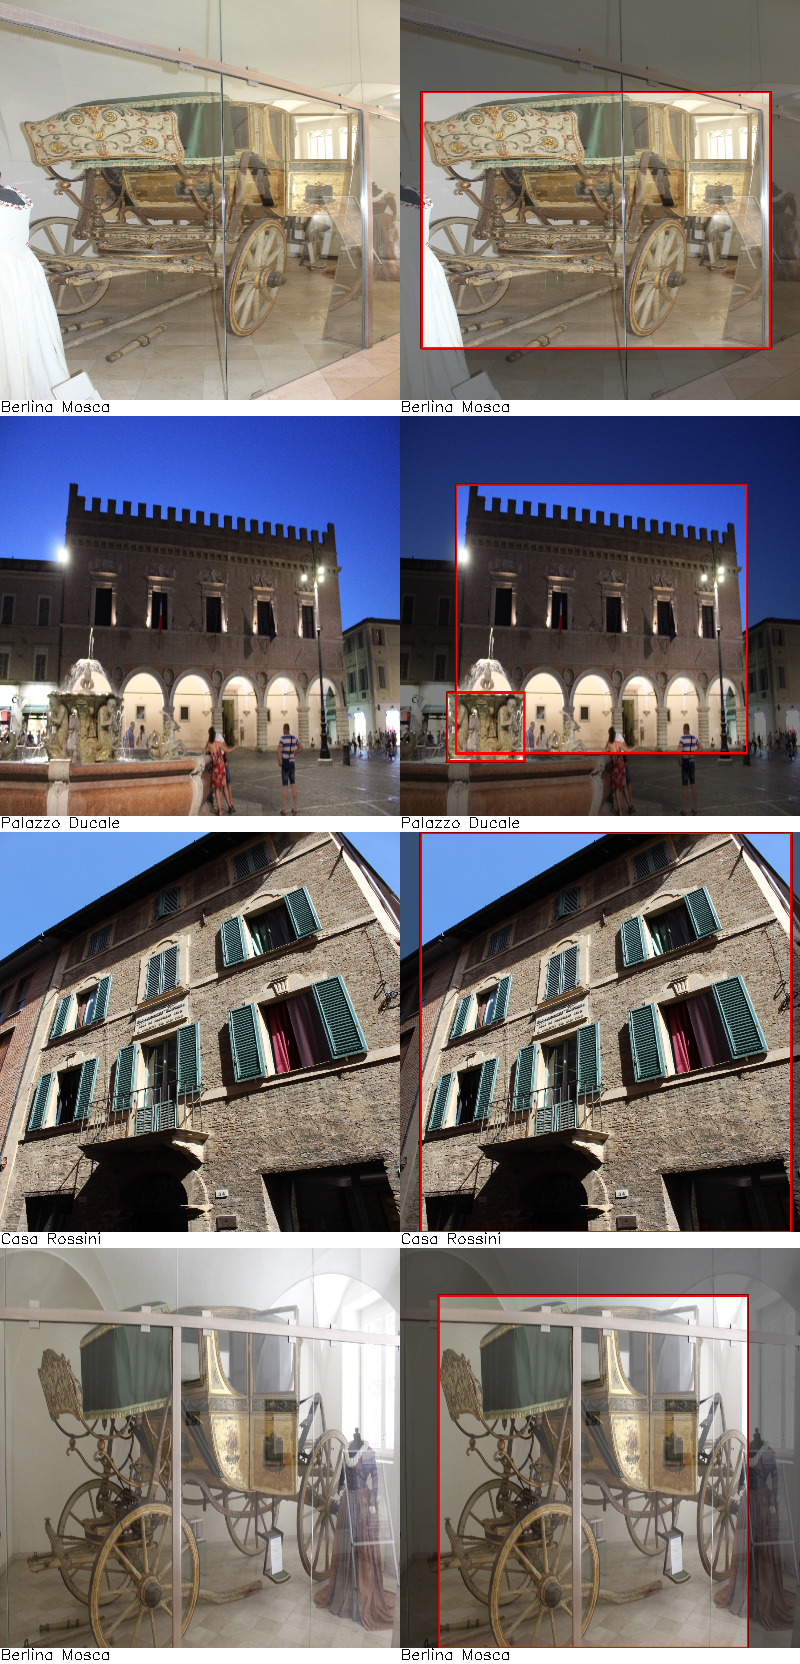

In [39]:
labels_to_show = []       # Labels of the images to show
bounding_box_list = []    # List of the boudning boxes drawed.
imgs_read_list = []       # List of the images read (no trasformations)
imgs_list = []            # List of the images trasformated (with bouding boxes)
title_images_list = []    # Label formattated.

labels_to_show.append(random.randint(0, len(dirs) - 1))
labels_to_show.append(random.randint(0, len(dirs) - 1))
labels_to_show.append(random.randint(0, len(dirs) - 1))
labels_to_show.append(random.randint(0, len(dirs) - 1))

for i in range(4):
    alpha = 0.5
    bounding_box_list.clear()

    index_label = labels_to_show[i]
    class_label = dataset[index_label]

    imgs = class_label.img_list
    annotations = class_label.annotation_list
    label = class_label.label_ds

    index_img = random.randint(0, len(imgs) - 1)

    # Parse xml
    tree = ET.parse(annotations[index_img])
    root = tree.getroot()

    # Get bounding boxes
    bounding_box_list, _ = get_bounding_boxes(annotations[index_img])

    # Image
    img_read = cv.imread(imgs[index_img])

    img_original = cv.resize(img_read, (400,400))
    imgs_read_list.append(img_original)

    # Mask
    mask = np.zeros_like(img_read[:, :, 0])

    for j, box in enumerate(bounding_box_list):
        # Draw rectangle
        cv.rectangle(img_read, convert_point_to_tuple(box[0]), convert_point_to_tuple(box[1]), (0, 0, 255), 5)

        polygon = np.array([[bounding_box_list[j][0]], [[bounding_box_list[j][1][0],
                            bounding_box_list[j][0][1]]], [bounding_box_list[j][1]],
                            [[bounding_box_list[j][0][0], bounding_box_list[j][1][1]]]])
        
        cv.fillConvexPoly(mask, polygon, 1)

    # Get polygon
    img = cv.bitwise_and(img_read, img_read, mask=mask)
    img = cv.addWeighted(img_read.copy(), alpha, img, 1 - alpha, 0)
    img = cv.resize(img, (400, 400))
    imgs_list.append(img)

    title_images_list.append(class_label.label_name)


imgs_stack = stack_images(1, ([draw_description(imgs_read_list[0], title_images_list[0]), draw_description(imgs_list[0], title_images_list[0])],
                              [draw_description(imgs_read_list[1], title_images_list[1]), draw_description(imgs_list[1], title_images_list[1])],
                              [draw_description(imgs_read_list[2], title_images_list[2]), draw_description(imgs_list[2], title_images_list[2])],
                              [draw_description(imgs_read_list[3], title_images_list[3]), draw_description(imgs_list[3], title_images_list[3])]))

cv2_imshow(imgs_stack)

### Trainining, validation e test set

La funzione *split_dataset* suddivide il dataset in training, validation e test set rispettivamente al 70% (training), 20% (validation) e 10% (test).

In [40]:
def split_dataset(dataset):
    r"""
    Split dataset in training, validation and test set:
        - 70% training set;
        - 20% validation set:
        - 10% test set.

    :param dataset: dataset to split.
    
    :return : training, validation and test set.
    """
    length_dataset = len(dataset)

    length_train = np.int_(length_dataset * 0.7)
    length_validate = np.int_(length_dataset * 0.2)

    training_dataset = Subset(dataset, range(0, length_train))
    validation_dataset = Subset(dataset, range(length_train, length_train + length_validate))

    dataset.transofrms = get_transform(train=False)     # Disabled the transforms for test set
    test_dataset = Subset(dataset, range(length_train + length_validate, len(dataset)))

    return training_dataset, validation_dataset, test_dataset

Partizionamento dataset.

In [41]:
trainining_set = []
validation_set = []
test_set = []

for _set in dataset:
    
    training_dataset, validation_dataset, test_dataset = split_dataset(_set)

    trainining_set.append(training_dataset)
    validation_set.append(validation_dataset)
    test_set.append(test_dataset)

training_dataset, validation_dataset, test_dataset = ConcatDataset(trainining_set), ConcatDataset(validation_set), \
                                                     ConcatDataset(test_set)

print(f"** Dataset caricato correttamente! Totale immagini: {len(training_dataset) + len(validation_dataset) + len(test_dataset)} **\n")
print(f"Dimensione training: {len(training_dataset)} immagini - (70%)")
print(f"Dimensione validation: {len(validation_dataset)} immagini - (20%)")
print(f"Dimensione test: {len(test_dataset)} immagini - (10%)\n\n")
print(f"Totale immagini suddivise: {len(training_dataset) + len(validation_dataset) + len(test_dataset)}\n\n")

** Dataset caricato correttamente! Totale immagini: 953 **

Dimensione training: 657 immagini - (70%)
Dimensione validation: 181 immagini - (20%)
Dimensione test: 115 immagini - (10%)


Totale immagini suddivise: 953




Creazione del *DataLoader* rispettivamente per training, validation e test set.

In [42]:
batch_size = 8

# Training set
training_loader = DataLoader(training_dataset,
                             batch_size=batch_size,
                             shuffle=True,
                             num_workers=4,
                             collate_fn=utils.collate_fn)

# Validation set
validation_loader = DataLoader(validation_dataset,
                               batch_size=batch_size,
                               shuffle=True,
                               num_workers=4,
                               collate_fn=utils.collate_fn)

# Test set
test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=False,
                         num_workers=4,
                         collate_fn=utils.collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Modello della rete

La funzione *get_model* inizializza la rete neurale Faster R-CNN preaddestrata.

In [43]:
def get_model(num_classes):
  r"""
  Model initialization.
  
  :param num_classes: number of classes of the problem.
  """

  # Load the model pretrained
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

  # Get number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  return model

Modifica del modello aggiungendo una specifica backbone.

In [44]:
# backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# backbone.out_channels = 1280

# anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
#                                   aspect_ratios=((0.5, 1.0, 2.0),))

# roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
#                                                output_size=7,
#                                                sampling_ratio=2)


Definizione del modello

In [45]:
# Classes
num_classes = len(total_labels) + 1  # N classes + background

# Model
model = get_model(num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Runtime used: {device}\n\n")
model = model.to(device)

params = [p for p in model.parameters() if p.requires_grad]

# Optimizer
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9,
                            weight_decay=0.0005)

# learning rate withStep LR
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)
# Epoch
num_epochs = 100

print("** SUMMARY TRAINING **\n")
print(f"- Classes of the problem: {num_classes};")
print(f"- Epochs number: {num_epochs};")
print(f"- Batch size: {batch_size};")
print(F"- Optimizer: {optimizer.__class__.__name__},")
print(f"             Learning Rate: {optimizer.defaults['lr']},")
print(f"             Momentum: {optimizer.defaults['momentum']}.")

Runtime used: cuda


** SUMMARY TRAINING **

- Classes of the problem: 26;
- Epochs number: 100;
- Batch size: 8;
- Optimizer: SGD,
             Learning Rate: 0.005,
             Momentum: 0.9.


## Addestramento

In [46]:
class Loss:
  r"""
  Class to calculate loss for every epoch during training model.
  """

  def __init__(self):
    """
    Constructor class.
    """
    self.current_total = 0.0
    self.iterations = 0.0

  def set(self, value):
    """
    Sets new value loss.

    :param value: new value.
    """
    self.current_total += value
    self.iterations += 1

  @property
  def value(self):
    """
    Get value of loss.
    """
    if self.iterations == 0:
        return 0
    else:
        return 1.0 * self.current_total / self.iterations

  def reset(self):
    """
    Reset loss value.
    """
    self.current_total = 0.0
    self.iterations = 0.0


def get_predictions(predictions, image_size=224, iou_thr=0.55, skip_box_thr=0.5, weights=None):
  
    print(f"Len predictions: {len(predictions)}")

    boxes = [prediction['boxes'].data.cpu().numpy()/(image_size - 1) for prediction in predictions]
    scores = [prediction['scores'].data.cpu().numpy() for prediction in predictions]
    labels = [np.ones(prediction['scores'].shape[0]) for prediction in predictions]

    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size - 1)

    return boxes, scores, labels

def calculate_image_precision(ground_through, predictions, thresholds):
    r"""Calculates image precision.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        thresholds: (float) Different thresholds
        form: (str) Format of the coordinates

    Return:
        (float) Precision
    """
    n_threshold = len(thresholds)
    image_precision = 0.0
    
    ious = np.ones((len(ground_through), len(predictions))) * - 1
    # ious = None

    for threshold in thresholds:
        precision_at_threshold = calculate_precision(ground_through.copy(), predictions, threshold = threshold, ious = ious)
        image_precision += precision_at_threshold / n_threshold

    return image_precision

def calculate_precision(ground_through, predictions, threshold, ious=None):
    """Calculates precision for GT - prediction pairs at one threshold.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (float) Precision
    """
    n = len(predictions)
    tp = 0
    fp = 0
    
    # for pred_idx, pred in enumerate(preds_sorted):
    for pred_idx in range(n):

        best_match_gt_idx = find_best_match(ground_through, predictions[pred_idx], pred_idx,
                                            threshold=threshold, ious=ious)

        if best_match_gt_idx >= 0:
            # True positive: The predicted box matches a ground through box with an IoU above the threshold.
            tp += 1
            # Remove the matched ground_through box
            ground_through[best_match_gt_idx] = -1

        else:
            # No match
            # False positive: indicates a predicted box had no associated ground through box.
            fp += 1

    # False negative: indicates a ground through box had no associated predicted box.
    fn = (ground_through.sum(axis=1) > 0).sum()

    return tp / (tp + fp + fn)

def find_best_match(ground_through, prediction, pred_idx, threshold, ious=None):
    """Returns the index of the 'best match' between the
    ground-truth boxes and the prediction. The 'best match'
    is the highest IoU. (0.0 IoUs are ignored).

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        pred: (List[Union[int, float]]) Coordinates of the predicted box
        pred_idx: (int) Index of the current predicted box
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (int) Index of the best match GT box (-1 if no match above threshold)
    """
    best_match_iou = -np.inf
    best_match_idx = -1

    for ground_throught_idx in range(len(ground_through)):
        
        if ground_through[ground_throught_idx][0] < 0:
            # Already matched ground through-box
            continue
        
        iou = -1 if ious is None else ious[ground_throught_idx][pred_idx]

        if iou < 0:
            iou = calculate_iou(ground_through[ground_throught_idx], prediction)
            
            if ious is not None:
                ious[ground_throught_idx][pred_idx] = iou

        if iou < threshold:
            continue

        if iou > best_match_iou:
            best_match_iou = iou
            best_match_idx = ground_throught_idx

    return best_match_idx

def calculate_iou(ground_throught, prediction):
    """Calculates the Intersection over Union.

    Args:
        gt: (np.ndarray[Union[int, float]]) coordinates of the ground-truth box
        pr: (np.ndarray[Union[int, float]]) coordinates of the prdected box
        form: (str) gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        (float) Intersection over union (0.0 <= iou <= 1.0)
    """

    # Calculate overlap area
    dx = min(ground_throught[2], prediction[2]) - \
         max(ground_throught[0], prediction[0]) + 1
    
    if dx < 0:
        return 0.0
    
    dy = min(ground_throught[3], prediction[3]) - \
         max(ground_throught[1], prediction[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = ((ground_throught[2] - ground_throught[0] + 1) * \
            (ground_throught[3] - ground_throught[1] + 1) + \
            (prediction[2] - prediction[0] + 1) * \
            (prediction[3] - prediction[1] + 1) - \
            overlap_area)

    return overlap_area / union_area


In [47]:
def training_loop(model, training_data, validation_data, num_epochs, optimizer, lr_scheduler, patience=2):
  r"""
  Training model.
  Save the best model trained.

  :param model: model net.
  :param training_data: training data.
  :param validation_data: validation data. 
  :param num_epochs: number of training epochs.
  :param optimizer: optimizer.
  :param lr_scherduler: scheduler.
  :param patience: number of epochs in which validation IoU can decrease.
  """

  try:
    # Create directory to save model
    os.mkdir("model")
  except:
    pass

  best_validation = None
  loss = Loss()
  model_path = f"model/fasterrcnn_cultural_heritage_{num_epochs}.pth"

  #               #
  # Training loop #
  #               #

  for epoch in range(num_epochs):

    print(f"Epoch: [{epoch + 1}]\n")
    start_time = time.time()
    iterations = 1
    loss.reset()

    model.train()

    for imgs, targets in training_data:

       imgs = list(img.to(device) for img in imgs)
       targets = [{k: v.to(device) if k =='labels' else v.float().to(device) for k, v in t.items()} for t in targets]

       loss_dict = model(imgs, targets)

       # Get loss and update
       losses = sum(loss for loss in loss_dict.values())
       loss_value = losses.item()
       loss.set(loss_value)

       optimizer.zero_grad()
       losses.backward()
       optimizer.step()

       if iterations % 20 == 0:
            print(f"- Training: iteration: {iterations} of epoch {epoch + 1}, loss: {loss_value}\n")

       iterations += 1

    # Update the learning rate
    lr_scheduler.step()

    #                 #
    # Validation loop #
    #                 #

    # Calculate IOU
    validation_image_precisions = []
    iou_thresholds = [x for x in np.arange(0.5, 0.76, 0.05)]
    model.eval()

    for imgs, targets in validation_data:

      imgs = list(img.to(device) for img in imgs)
      targets = [{k: v.to(device) if k =='labels' else v.float().to(device) for k, v in t.items()} for t in targets]

      outputs = model(imgs) 

      for i, image in enumerate(imgs):
          #boxes, scores, labels = get_predictions(outputs)
          #boxes = boxes.astype(np.int32).clip(min=0, max=1023)
          #predictions = boxes
          
          predictions = outputs[i]['boxes'].data.cpu().numpy()
          scores = outputs[i]['scores'].data.cpu().numpy()

          predictions_sorted_idx = np.argsort(scores)[::-1]
          predictions_sorted = predictions[predictions_sorted_idx]

          ground_through_boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)

          image_precision = calculate_image_precision(ground_through_boxes,
                                                      predictions_sorted,
                                                      thresholds = iou_thresholds)
          
          validation_image_precisions.append(image_precision)

    print(validation_image_precisions)
    val_iou = np.mean(validation_image_precisions)
    print(f"- Epoch: {epoch + 1} Loss: {loss.value}, ","Validation IoU: {0:.4f}, ".format(val_iou),"Time:",str(datetime.timedelta(seconds=time.time() - start_time))[:7] + "\n")

    if not best_validation:
      best_validation = val_iou       # So any validation roc_auc we have is the best one for now
      print("[Saving model]\n")
      torch.save(model, model_path)   # Saving the model
      continue

    if val_iou > best_validation:
      print("[Saving model as IOU is increased from", best_validation, "to", val_iou, "]\n")
      best_validation = val_iou
      patience = 2                    # Resetting patience since we have new best validation accuracy
      torch.save(model, model_path)   # Saving current best model torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')

    elif val_iou == best_validation:
      patience = 2
      continue

    else:
      patience -= 1
      print("[Decrease patience!]\n")

      if patience == 0:
          print('Early stopping. Best Validation IoU: {:.3f}\n'.format(best_validation))
          break

In [ ]:
# Addestramento
training_loop(model, training_loader, validation_loader, num_epochs, optimizer, lr_scheduler)

Epoch: [1]



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Risultati ottenuti

In [ ]:
# Caricamento del modello addestrato
path = "model/fasterrcnn_cultural_heritage_100"
model = torch.load(path)
model.eval()

In [ ]:
detection_threshold = 0.5

results = []
test_images = []

for images, image_ids in test_loader:

    images = list(image.to(device) for image in images)
    #predictions = make_ensemble_predictions(images)

    outputs = model(images) 

    for i, image in enumerate(images):
        test_images.append(image) #Saving image values

        #boxes, scores, labels = get_predictions(predictions)
        #boxes = boxes.astype(np.int32).clip(min=0, max=1023)
        #preds = boxes

        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        label = outputs[i]['labels'].data.cpu().numpy()

        predictions = boxes
        preds_sorted_idx = np.argsort(scores)[::-1]
        preds_sorted = predictions[preds_sorted_idx]
        boxes = predictions
        
        output = {
            'boxes': boxes,
            'scores': scores,
            'labels': label,
        }

        results.append(output) # Saving outputs and scores
        image_id = image_ids[i]

In [ ]:
from matplotlib import pyplot as plt
#imgs = []
#labels = []

fig, axs = plt.subplots(2, 3, figsize=(32, 16))
axs = axs.ravel()

for i in range(6):

    index = random.randint(0, len(test_images) -1)
    img = test_images[index]
    result = results[index]

    del test_images[index]
    del results[index]

    sample = img.permute(1,2,0).cpu().numpy()

    boxes = result['boxes']
    scores = result['scores']
    #label = result['labels']
    #labels.append(label)

    boxes = boxes[scores >= detection_threshold].astype(np.int32)

    for box in boxes:
        cv.rectangle(sample,
                    (box[0], box[1]),
                    (box[2], box[3]),
                    (0, 0, 255), 5)
        
    #sample = cv.resize(sample, (400, 400))
    #imgs.append(sample)

    axs[i].set_axis_off()
    axs[i].imshow(sample)

#imgs_stack = stack_images(1, ([imgs[0], imgs[1]],
#                             [imgs[2], imgs[3]]))

#cv2_imshow(imgs_stack)

Note:

- Verificare se per il test set, le operazioni di data augmentation non vengono effettuate;

- Valutare se aggiungere la modifica della backbone della rete;

- Valutare se migliorare la suddivisione del datatset: in questo caso prima caricare le immagini, splittarle e solo alla fine creare la classe del dataset. Cosi si distingue il tipo di dataset (training, validation, test) per la creazione della classe e del tipo di trasformazione da applicare.

Errori:

- bug di albumentations con i riquadri delle bb. In attesa di risolvere, ho modificato la funzione *get_transform* e la sua chiamata nella classe del dataset.

- non riesco a creare bounding box per immagini senza oggetti. Ottengo validation = Nan

- completare l'addestramento con un numero consistente di epoche.